<a href="https://colab.research.google.com/github/ChiragTutlani/Snakes-Breed-Detector/blob/main/Snakes_Breed_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2 as cv
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output
from tensorflow.keras import layers, Sequential
import shutil
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!unzip "/content/drive/My Drive/dataset_snakes_hood.zip" -d "/content/drive/My Drive"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/dataset/train/b70a166bfe.jpg  
  inflating: /content/drive/My Drive/dataset/train/d31875b68e.jpg  
  inflating: /content/drive/My Drive/dataset/train/22c66793fb.jpg  
  inflating: /content/drive/My Drive/dataset/train/a468b1390f.jpg  
  inflating: /content/drive/My Drive/dataset/train/9e43d2cedc.jpg  
  inflating: /content/drive/My Drive/dataset/train/2e0299e991.jpg  
  inflating: /content/drive/My Drive/dataset/train/e0b85d8ff1.jpg  
  inflating: /content/drive/My Drive/dataset/train/6a651ec04a.jpg  
  inflating: /content/drive/My Drive/dataset/train/46c87716a5.jpg  
  inflating: /content/drive/My Drive/dataset/train/8c40d4f073.jpg  
  inflating: /content/drive/My Drive/dataset/train/96e4fb744c.jpg  
  inflating: /content/drive/My Drive/dataset/train/794a698960.jpg  
  inflating: /content/drive/My Drive/dataset/train/dad1934f35.jpg  
  inflating: /content/drive/My Drive/dataset/train/a1c66a2b3c.jpg

In [3]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3
BATCH_SIZE = 32

train_img_folder = 'drive/MyDrive/dataset/train'
train_structured_img_folder = 'drive/MyDrive/dataset/train_structured'
train_structured_session_folder = 'train_structured'

train_csv = 'drive/MyDrive/dataset/train.csv'

In [4]:
def delete_dir_recursively(dir_name):
  if not os.path.exists(dir_name):
    return
  
  files = os.listdir(dir_name)

  for filename in files:
    if os.path.isdir(os.path.join(dir_name, filename)):
      delete_dir_recursively(os.path.join(dir_name, filename))
    else:
      os.remove(os.path.join(dir_name, filename))

  os.rmdir(dir_name)

In [5]:
def reshape_images(source_folder, target_folder):
    image_files = os.listdir(path=source_folder)
    
    for filename in image_files:
        if '.jpg' in filename:
            img = cv.imread(os.path.join(source_folder, filename),
                            cv.IMREAD_COLOR)
            img_reshaped = cv.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT),
                                     cv.INTER_CUBIC)

            if not os.path.exists(target_folder):
                os.mkdir(target_folder)
            
            cv.imwrite(os.path.join(target_folder, filename), img_reshaped)

In [6]:
def augment_images(source_folder, target_folder):
    image_files = os.listdir(path=source_folder)
    
    for i in range(len(image_files)):
        filename = image_files[i]

        if '.jpg' in filename:
            img = cv.imread(os.path.join(source_folder, filename), cv.IMREAD_COLOR)
            name_wo_ext, ext = filename.split('.')
            ext = '.' + ext
            
            img_90 = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)
            img_180 = cv.rotate(img_90, cv.ROTATE_90_CLOCKWISE)
            img_270 = cv.rotate(img_180, cv.ROTATE_90_CLOCKWISE)

            if not os.path.exists(target_folder):
                os.mkdir(target_folder)

            cv.imwrite(os.path.join(target_folder, name_wo_ext + '_0' + ext), img)
            cv.imwrite(os.path.join(target_folder, name_wo_ext + '_90' + ext), img_90)
            cv.imwrite(os.path.join(target_folder, name_wo_ext + '_180' + ext), img_180)
            cv.imwrite(os.path.join(target_folder, name_wo_ext + '_270' + ext), img_270)

            if i%5==0:
                clear_output(wait=True)
                print("Total Files: {} | Files Augmented: {}".format(len(image_files),i+1))

In [7]:
def make_structured_dir(source_folder, target_folder, csv_file):
    target_df = pd.read_csv(csv_file)

    image_files = os.listdir(source_folder)
    for i in range(len(image_files)):
        filename = image_files[i]
        if '.jpg' in filename:

            filename_wo_ext = filename.split('.')[0]
            if '_' in filename_wo_ext:
                filename_wo_ext = filename_wo_ext.split('_')[0]
            
            new_folder_name = target_df[ target_df['image_id'] == filename_wo_ext]['breed'].iloc[0]
            new_dir_name = os.path.join(target_folder, new_folder_name)

            if not os.path.exists(target_folder):
                os.mkdir(target_folder)

            if not os.path.exists(new_dir_name):
                os.mkdir(new_dir_name)

            shutil.copy(os.path.join(source_folder, filename), 
                      os.path.join(new_dir_name, filename))
        
        if i%5==0:
            clear_output(wait=True)
            print("Total Files: {} | Files Structured: {}".format(len(image_files),i+1))

    clear_output(wait=True)
    print("Total Files Done: {}".format(len(image_files)))

In [42]:
def plot_train_validation_acc(history, epochs):
    train_loss = np.array(history['loss'])
    validation_loss = np.array(history['val_loss'])
    train_acc = (1.0 - train_loss).reshape(-1,1)
    validation_acc = (1.0 - validation_loss).reshape(-1,1)

    epochs_range = np.array(range(1, epochs + 1)).reshape(-1,1)
    
    plt.plot(epochs_range, train_acc, label='Train',
             linestyle='solid', color='blue', linewidth=1)
    plt.plot(epochs_range, validation_acc, label='Validation',
             linestyle='solid', color='green', linewidth=1)
    plt.legend()
    plt.show()

In [12]:
make_structured_dir(train_img_folder, train_structured_session_folder, train_csv)

Total Files Done: 5508


In [13]:
train_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_structured_session_folder,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    validation_split=0.2,
    subset='training',
    seed=0
)
validation_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_structured_session_folder,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    validation_split=0.2,
    subset='validation',
    seed=0
)

Found 5508 files belonging to 35 classes.
Using 4407 files for training.
Found 5508 files belonging to 35 classes.
Using 1101 files for validation.


In [14]:
train_image_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 35)), types: (tf.float32, tf.float32)>

In [15]:
validation_image_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 35)), types: (tf.float32, tf.float32)>

In [16]:
rescale_and_augment = Sequential([
    layers.experimental.preprocessing.Rescaling(1.0 / 255),
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomRotation((-0.25, 0.25))
])

In [17]:
model = Sequential()

model.add(rescale_and_augment)

model.add(layers.Conv2D(16, kernel_size=2, activation='relu', padding='valid'))
model.add(layers.MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(layers.Conv2D(32, kernel_size=2, activation='relu', padding='valid'))
model.add(layers.MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(layers.Conv2D(64, kernel_size=2, activation='relu', padding='valid'))
model.add(layers.MaxPooling2D(pool_size=(2,2), padding='valid'))

model.add(layers.Conv2D(128, kernel_size=2, activation='relu', padding='valid'))
model.add(layers.MaxPooling2D(pool_size=(2,2), padding='valid'))

model.add(layers.Conv2D(256, kernel_size=2, activation='relu', padding='valid'))
model.add(layers.MaxPooling2D(pool_size=(2,2), padding='valid'))

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dropout(0.4))

model.add(layers.Dense(units=35, activation='softmax'))
model.build((None, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 255, 255, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)       

In [18]:
epochs = 30

model.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError())
history = model.fit(train_image_dataset, validation_data=validation_image_dataset,epochs=epochs, verbose=2)

Epoch 1/30
138/138 - 19s - loss: 0.0133 - val_loss: 0.0132
Epoch 2/30
138/138 - 11s - loss: 0.0133 - val_loss: 0.0132
Epoch 3/30
138/138 - 11s - loss: 0.0132 - val_loss: 0.0131
Epoch 4/30
138/138 - 11s - loss: 0.0132 - val_loss: 0.0132
Epoch 5/30
138/138 - 11s - loss: 0.0132 - val_loss: 0.0131
Epoch 6/30
138/138 - 11s - loss: 0.0132 - val_loss: 0.0131
Epoch 7/30
138/138 - 11s - loss: 0.0132 - val_loss: 0.0131
Epoch 8/30
138/138 - 11s - loss: 0.0132 - val_loss: 0.0131
Epoch 9/30
138/138 - 11s - loss: 0.0132 - val_loss: 0.0131
Epoch 10/30
138/138 - 12s - loss: 0.0131 - val_loss: 0.0131
Epoch 11/30
138/138 - 11s - loss: 0.0131 - val_loss: 0.0131
Epoch 12/30
138/138 - 12s - loss: 0.0131 - val_loss: 0.0131
Epoch 13/30
138/138 - 12s - loss: 0.0131 - val_loss: 0.0133
Epoch 14/30
138/138 - 12s - loss: 0.0131 - val_loss: 0.0131
Epoch 15/30
138/138 - 12s - loss: 0.0131 - val_loss: 0.0130
Epoch 16/30
138/138 - 12s - loss: 0.0131 - val_loss: 0.0130
Epoch 17/30
138/138 - 12s - loss: 0.0131 - val_lo

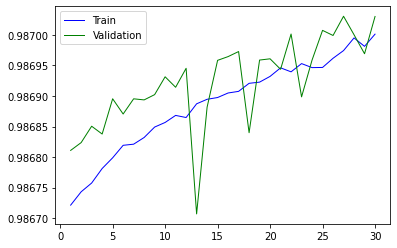

In [43]:
plot_train_validation_acc(history.history, epochs)

Delete Directory

In [10]:
delete_dir_recursively('drive/MyDrive/dataset')